Parameter setup for (7,4) hamnming code

In [4]:
# Message type
M = 2**4
# transmit len
N = 7
R = 4./7.

# Loading Libraries

In [1]:
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.experimental import AdamW


# Loading codebook file

In [2]:
def load_codebook(fname):
  df = pd.read_csv(fname)
  y = df[["x0", "x1", "x2", "x3", "x4", "x5", "x6"]].values
  m = df[["m0", "m1", "m2", "m3"]].values
  file_size = y.shape[0]
  m_modified = np.zeros(file_size)
  for i in range(file_size):
    m_modified[i] += m[i,0]*8+m[i,1]*4+m[i,2]*2+m[i,3]*1
  return y, m_modified, file_size

# Splitting data into training and testing

In [3]:
def splitting_data(y,m,rate,file_size):
  train_size = round(file_size*rate)
  test_size = file_size - train_size
  train_y = y[0:train_size,:]
  train_m = m[0:train_size]
  test_y = y[train_size:file_size,:]
  test_m = m[train_size:file_size]
  return train_y, train_m, test_y, test_m, train_size, test_size

# Load File

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')
path = "C:/Users/kenla/Desktop/113-2/AI_Lab_WC/codework/" # Setup the Path as your own
fname = path + "codeword_file_SNR=6.csv"

rate = 0.7 # training data rate
[y, m, file_size] = load_codebook(fname)
[train_y, train_m, test_y, test_m, train_size, test_size] = splitting_data(y, m, rate, file_size)
print("train_y shape: ", train_y.shape)
print("train_m shape: ", train_m.shape)
print(train_m[0:10])
print("test_y shape: ", test_y.shape)
print("test_m shape: ", test_m.shape)
# enable run function
tf.config.run_functions_eagerly(True)
tf.data.experimental.enable_debug_mode()
# test_m = train_m

unique_category_count = 16
train_m_OneHot = tf.one_hot(train_m, unique_category_count)
test_m_OneHot = tf.one_hot(test_m, unique_category_count)
print("train_m_OneHot shape: ", train_m_OneHot.shape)
print("test_m_OneHot shape: ", test_m_OneHot.shape)

train_y shape:  (140000, 7)
train_m shape:  (140000,)
test_y shape:  (60000, 7)
test_m shape:  (60000,)
train_m_OneHot shape:  (140000, 16)
test_m_OneHot shape:  (60000, 16)


# Training Part - Define a deep learning model for training

In [ ]:
# M = Input_dim, N = channel, SNR: Train on 0dB
# def AutoEncoder_Model(M, N, SNR_dB):
SNR_T = 10**(6/10)

# Encoder
Encoder = keras.Sequential([
    keras.layers.Dense(64, activation='elu', input_shape=(M,)),
    keras.layers.Dense(256, activation='elu'),
    # keras.layers.BatchNormalization(),
    keras.layers.Dense(256, activation='elu'),
    keras.layers.Dense(256, activation='elu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(N, activation='tanh'),
])
# Channel
noise_std = np.sqrt(1/(2*R*SNR_T))
Channel = keras.Sequential([
    keras.layers.GaussianNoise(noise_std, input_shape=(N,)),
])

# Decoder
Decoder = keras.Sequential([
    keras.layers.Dense(64, activation='elu', input_shape=(N,)),
    keras.layers.Dense(256, activation='elu'),
    # keras.layers.BatchNormalization(),
    keras.layers.Dense(256, activation='elu'),
    keras.layers.Dense(256, activation='elu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(M, activation='softmax'),
])

Decoder.summary()


AutoEncoder = keras.Sequential([Encoder, Channel, Decoder])



Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_25 (Dense)            (None, 64)                512       
                                                                 
 dense_26 (Dense)            (None, 256)               16640     
                                                                 
 dense_27 (Dense)            (None, 256)               65792     
                                                                 
 dense_28 (Dense)            (None, 256)               65792     
                                                                 
 batch_normalization_5 (Batc  (None, 256)              1024      
 hNormalization)                                                 
                                                                 
 dense_29 (Dense)            (None, 16)                4112      
                                                     

# Training Part - Train Model

In [31]:
optimizer = Adam(learning_rate=0.0001)
AutoEncoder.compile(optimizer=optimizer,
                loss='categorical_crossentropy',
                metrics=['acc'])
AutoEncoder.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_10 (Sequential)  (None, 7)                 152135    
                                                                 
 sequential_11 (Sequential)  (None, 7)                 0         
                                                                 
 sequential_12 (Sequential)  (None, 16)                153872    
                                                                 
Total params: 306,007
Trainable params: 304,983
Non-trainable params: 1,024
_________________________________________________________________


Epoch 1/10
92/92 [==============================] - 4s 43ms/step - loss: 0.4177 - acc: 0.9145 - val_loss: 1.8701 - val_acc: 1.0000
Epoch 2/10
92/92 [==============================] - 4s 48ms/step - loss: 0.0523 - acc: 0.9953 - val_loss: 0.8319 - val_acc: 1.0000
Epoch 3/10
92/92 [==============================] - 4s 43ms/step - loss: 0.0340 - acc: 0.9962 - val_loss: 0.1367 - val_acc: 1.0000
Epoch 4/10
92/92 [==============================] - 4s 43ms/step - loss: 0.0266 - acc: 0.9964 - val_loss: 0.0134 - val_acc: 1.0000
Epoch 5/10
92/92 [==============================] - 4s 45ms/step - loss: 0.0218 - acc: 0.9968 - val_loss: 0.0021 - val_acc: 1.0000
Epoch 6/10
92/92 [==============================] - 4s 46ms/step - loss: 0.0191 - acc: 0.9970 - val_loss: 6.6094e-04 - val_acc: 1.0000
Epoch 7/10
92/92 [==============================] - 4s 47ms/step - loss: 0.0170 - acc: 0.9972 - val_loss: 3.2550e-04 - val_acc: 1.0000
Epoch 8/10
92/92 [==============================] - 4s 46ms/step - loss: 0.

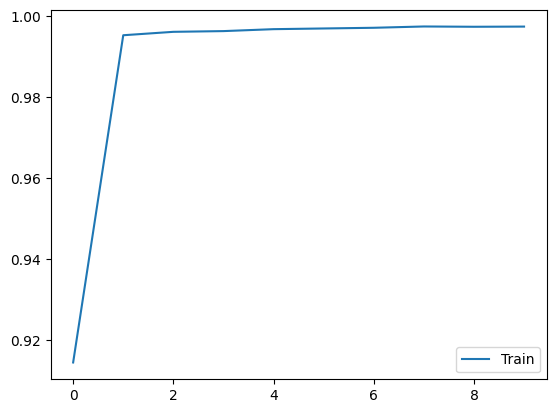

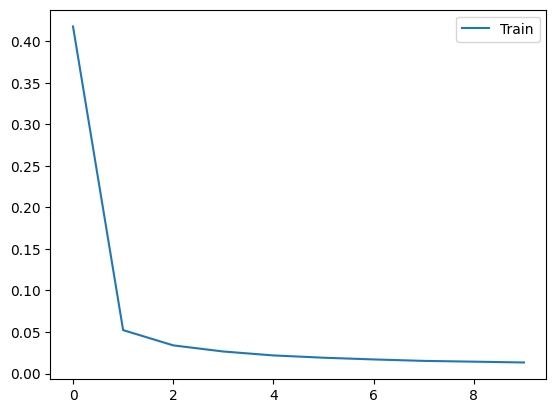

In [32]:
History = AutoEncoder.fit(train_m_OneHot, train_m_OneHot, epochs=10, batch_size=1536, validation_data=(test_m_OneHot, test_m_OneHot), verbose=1)

plt.figure()
plt.plot(History.history['acc'])
plt.legend(["Train"])
plt.figure()
plt.plot(History.history['loss'])
plt.legend(["Train"])

In [33]:
# Decoder
Decoder = keras.Sequential([keras.Input(shape=(N,)), Decoder])

# Inference Part - Build ENC & DEC for inference

In [34]:
# Define the Encoder
'''
    Copy layers' weights before channel (batchNorm) from Trained AutoEncoder
'''
Encoder.set_weights(AutoEncoder.layers[0].get_weights())
Encoder.summary()  # 打印 encoder 模型的摘要

# Define the Decoder
'''
    Copy layers' weights after channel (batchNorm) from Trained AutoEncoder
'''
Decoder.set_weights(AutoEncoder.layers[2].get_weights())
Decoder.summary()  # 打印 decoder 模型的摘要

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_20 (Dense)            (None, 64)                1088      
                                                                 
 dense_21 (Dense)            (None, 256)               16640     
                                                                 
 dense_22 (Dense)            (None, 256)               65792     
                                                                 
 dense_23 (Dense)            (None, 256)               65792     
                                                                 
 batch_normalization_4 (Batc  (None, 256)              1024      
 hNormalization)                                                 
                                                                 
 dense_24 (Dense)            (None, 7)                 1799      
                                                     

# Inference Part - Simulate over different SNR

In [35]:
SNR_start = 0
SNR_end = 6
step_size = 1
SNR = np.arange(SNR_start,SNR_end+step_size,step_size)
length_SNR = len(SNR)
BLER = np.zeros(length_SNR)
for i in range(length_SNR):
  print(str(SNR[i]) + "/" + str(SNR[-1]))
  snr = 10.0**(SNR[i]/10.0)
  noise = np.random.randn(test_size, N) * np.sqrt(1/(2*R*snr))

  # Encode
  print("Encoding...")
  # Encoder inference the test_m_OneHot
  Encoder_signals = Encoder.predict(test_m_OneHot)
  # print("test_m_OneHot: ",test_m_OneHot.shape)
  signal_power = np.mean(np.square(Encoder_signals), axis=0)
  
  # Channel
  noise *= np.sqrt(signal_power)
  recive_signals = Encoder_signals + noise

  # Decode
  print("Decoding...")
  # Decoder inference the recive signals
  Decoder_signals = Decoder.predict(recive_signals)
  Decoder_pred = np.argmax(Decoder_signals, axis=1)

  # Calulate the Error
  error = np.sum(Decoder_pred != np.argmax(test_m_OneHot, axis=1))
  # print("Error: ",error)
  # print("Decode_signals: ",Decoder_pred[0])
  # print("test_m: ",test_m[0])
  BLER[i] = error/test_size
  # print("test_size: ",test_size)
  print("BLER: ",BLER[i])

0/6
Encoding...
1875/1875 [==============================] - 10s 5ms/step
Decoding...
1875/1875 [==============================] - 10s 5ms/step
BLER:  0.20328333333333334
1/6
Encoding...
1875/1875 [==============================] - 11s 6ms/step
Decoding...
1875/1875 [==============================] - 9s 5ms/step
BLER:  0.13721666666666665
2/6
Encoding...
1875/1875 [==============================] - 11s 6ms/step
Decoding...
1875/1875 [==============================] - 10s 5ms/step
BLER:  0.08078333333333333
3/6
Encoding...
1875/1875 [==============================] - 11s 6ms/step
Decoding...
1875/1875 [==============================] - 9s 5ms/step
BLER:  0.04095
4/6
Encoding...
1875/1875 [==============================] - 11s 6ms/step
Decoding...
1875/1875 [==============================] - 9s 5ms/step
BLER:  0.018816666666666666
5/6
Encoding...
1875/1875 [==============================] - 9s 5ms/step
Decoding...
1875/1875 [==============================] - 10s 5ms/step
BLER:  0.0062833

# Inference Part - Figure Plot

[0.20328333 0.13721667 0.08078333 0.04095    0.01881667 0.00628333
 0.00201667]


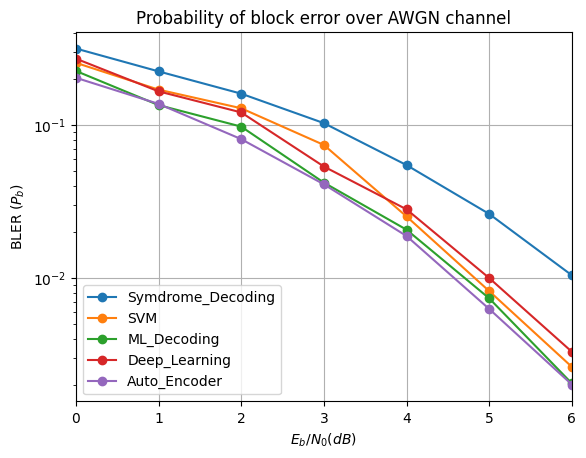

Block Error Rate: [0.20328333 0.13721667 0.08078333 0.04095    0.01881667 0.00628333
 0.00201667]
Name: 賴昱凱, Student ID: 111511141


In [36]:
# Plot BLER
SNR_start = 0
SNR_end = 6
BLER_SymdromeDecoding = [0.3155, 0.22375, 0.16, 0.10275, 0.054675, 0.026215, 0.010425]
BLER_SVM = [0.2545, 0.17, 0.1285, 0.074, 0.02525, 0.00822, 0.00263]
BLER_ML = [0.22525, 0.13475, 0.0975, 0.042, 0.02069, 0.00737, 0.00205]
BLER_DL = [0.2710, 0.1657, 0.1207, 0.0535, 0.0281, 0.01, 0.0033]
print(BLER)
# EbN0dBs = np.arange(start=SNR_start,stop=SNR_end+step_size,step=step_size)
EbN0dBs = [x for x in range(0,7)]
fig = plt.figure()
plt.semilogy(EbN0dBs,BLER_SymdromeDecoding,marker='o',linestyle='-',label='Symdrome_Decoding')
plt.semilogy(EbN0dBs,BLER_SVM,marker='o',linestyle='-',label='SVM')
plt.semilogy(EbN0dBs,BLER_ML,marker='o',linestyle='-',label='ML_Decoding')
plt.semilogy(EbN0dBs,BLER_DL,marker='o',linestyle='-',label='Deep_Learning')
plt.semilogy(EbN0dBs,BLER,marker='o',linestyle='-',label='Auto_Encoder')
plt.xlabel('$E_b/N_0(dB)$');plt.ylabel('BLER ($P_b$)')
plt.title('Probability of block error over AWGN channel')
plt.xlim(SNR_start,SNR_end);plt.grid(True);
plt.legend()
plt.show()
print("Block Error Rate:", BLER)
print("Name: 賴昱凱, Student ID: 111511141")